In [1]:
import numpy as np
# import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
from utils import *
from MoDL.MoDL import MoDL
from matplotlib import pyplot as plt
import random
import copy
# from sklearn.model_selection import train_test_split

import skimage
from mnet.mnet_v2 import MNet
from unet.unet_model import UNet
from unet.unet_model_fbr import Unet
from unet.unet_model_banding_removal_fbr import UnetModel
from mask_backward_v4 import *
from sigpy.mri.app import TotalVariationRecon

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
reload(utils)
from utils import *

# Evaluation

In [2]:
testdata = torch.tensor(np.load('/mnt/shared_a/fastMRI/knee_singlecoil_test.npz')['data'])
print('test data shape: ',testdata.shape)

test data shape:  torch.Size([1300, 320, 320])


In [ ]:
# load mnet
sparsity = .125
preselect_num = 8
budget = int(testdata.shape[1]*sparsity - preselect_num)
print('sampling budget = ', budget)

mnet = MNet(beta=1,in_channels=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3).cpu()
mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_split_trained_cf_8_bg_32_unet_in_chan_1_epoch_9.pt'

checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

modl = MoDL(in_chans=2,out_chans=2,chans=32,num_pool_layers=4,drop_prob=0)
modlpath = '/mnt/shared_a/checkpoints/leo/recon/MoDL_2_chans_32_epoch_9.pt'
checkpoint = torch.load(modlpath)
modl.load_state_dict(checkpoint['model_state_dict'])
print(f'MoDL model loaded successfully from {modlpath}')
# unet_skip = False
# unet_inchannels = 2
# unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=128).cpu()
# unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_128_epoch_19.pt'

# checkpoint = torch.load(unetpath)
# unet_recon.load_state_dict(checkpoint['model_state_dict'])
# print('Unet loaded successfully from: ' + unetpath )
# unet_recon.eval()
# print('nn\'s are ready')


In [ ]:
def load_data_for_recon(batch,testdata,mnet,budget=32,unet_inchans=2,device=torch.device('cpu')):
    '''
    testdata should have the format NHW
    '''
    xstar = testdata[batch,:,:].to(torch.float).to(device)
    for img in xstar:
        img /= img.abs().max()
    yfull = F.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho'),dim=(1,2)) # y is ROLLED!

    y = torch.zeros((yfull.shape[0],2,yfull.shape[1],yfull.shape[2]),dtype=torch.float,device=device)
    lowfreqmask = mask_naiveRand(testdata.shape[1],fix=testdata.shape[1]-budget,other=0,roll=True)[0].to(device)
    y[:,0,lowfreqmask==1,:] = torch.real(yfull)[:,lowfreqmask==1,:]
    y[:,1,lowfreqmask==1,:] = torch.imag(yfull)[:,lowfreqmask==1,:]
    mask_test = mnet_wrapper(mnet,y,budget,(testdata.shape[1],testdata.shape[2]),\
                             normalize=True,detach=True,device=device)

    z = torch.zeros(xstar.shape,device=device).to(torch.cfloat)
    for ind in range(len(xstar)):
        z[ind,mask_test[ind,:]==1,:] = y[ind,0,mask_test[ind,:]==1,:] + 1j*y[ind,1,mask_test[ind,:]==1,:]
    z = torch.fft.ifftshift(z , dim=(1,2))  # y is ROLLED BACK!

    if unet_inchans == 1:
        x_ifft = torch.abs( F.ifftn(z,dim=(1,2),norm='ortho') )
        x_in   = x_ifft.view(len(xstar),1,testdata.shape[1],testdata.shape[2])
    elif unet_inchans == 2:
        x_ifft = F.ifftn(z,dim=(1,2),norm='ortho') 
        x_in   = torch.zeros((len(xstar),2,testdata.shape[1],testdata.shape[2]),device=device)
        x_in[:,0,:,:] = torch.real(x_ifft)
        x_in[:,1,:,:] = torch.imag(x_ifft)
    return x_in, xstar

In [ ]:
batch = torch.arange(0,2)
x_in, xstar =  load_data_for_recon(batch,testdata,mnet)
print(xstar.shape)

In [ ]:
x_out = unet_recon(x_in).detach()
print(x_out.shape)
xstar = torch.unsqueeze(xstar,1)

In [ ]:
plt.figure()
plt.title('unet out')
plt.imshow(x_out[1,0,:,:])
plt.colorbar()
plt.show()

plt.figure()
plt.title('ground truth')
plt.imshow(xstar[1,0,:,:])
plt.colorbar()
plt.show()

In [ ]:
win_size = np.arange(2,13)
ssims = np.zeros(win_size.shape[0])
for ind in range(win_size.shape[0]):
    ssims[ind] = ssim_uniform(x_out,xstar,window_size=win_size[ind])
plt.figure()
plt.plot(ssims)
plt.show()
print(f'The window size that minimizes ssim: {win_size[np.argmin(ssims)]}')

In [ ]:
ssim_uniform(x_out,xstar,window_size=4)

In [ ]:
np.mean(compute_ssim(x_out[:,0,:,:],xstar[:,0,:,:]))

In [ ]:
l1err,l2err,hfens,ssims,psnrs = mnet_eval(testdata,mnet,modl,budget,batchsize=5,device='cuda:0')

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

# comparison between MNet and Loupe

In [ ]:
dtyp = torch.float
testxdata  = np.load('/home/huangz78/data/testdata_x.npz')
testydata  = np.load('/home/huangz78/data/testdata_y.npz')
testxfull = torch.tensor(testxdata['xfull'],dtype=dtyp)
testyfull = torch.tensor(testydata['yfull'],dtype=torch.cfloat)

In [ ]:
# sparsity = .25
# preselect_num = 24
# unet_skip = True

sparsity = .125
preselect_num = 8
# unet_skip = True

In [ ]:
# load mnet
mnet = MNet(beta=1,in_channels=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3)
# mnetpath = '/home/huangz78/checkpoints/mnet.pth'
mnetpath = '/mnt/DataA/checkpoints/leo/mri/mnet_split_trained_cf_8_bg_32_unet_in_chan_1_epoch_12.pt'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

# unet_recon = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# unetpath = '/home/huangz78/checkpoints/unet_1_True.pth'
# checkpoint = torch.load(unetpath)
# unet_recon.load_state_dict(checkpoint['model_state_dict'])
# print('Unet loaded successfully from: ' + unetpath )
# unet_recon.eval()
# print('nn\'s are ready')

In [ ]:
mnet_test_mode = 'sigpy'
ssim_mnet,psnr_mnet,hfen_mnet,rmse_mnet = mnet_eval(mnet,unet_recon,testyfull,preselect_num=24,sparsity=.25,\
                               batchsize=5,mode=mnet_test_mode,normalize=False)

In [ ]:
print('mnet test mode: ',mnet_test_mode)
print('ssim mnet: ',np.mean(ssim_mnet))
print('psnr mnet: ',np.mean(psnr_mnet))
print('hfen mnet: ',np.mean(hfen_mnet))
print('rmse mnet: ',np.mean(rmse_mnet))

In [ ]:
# load unet
unet_skip = False
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# load loupe model
loupepath = '/home/huangz78/checkpoints/loupe_skipTrue.pt'
loupe = LOUPE(n_channels=1,unet_skip=True,shape=[320,320],slope=5,sparsity=sparsity,\
                  preselect=True,preselect_num=preselect_num,\
                  sampler=None,unet=UNET)

In [ ]:
loupe_test_mode = 'unet'
ssim_loupe,psnr_loupe,hfen_loupe,rmse_loupe = loupe_eval(loupe,testyfull,preselect_num=24,sparsity=.25,\
                               batchsize=5,mode=loupe_test_mode)

In [ ]:
print('mnet test mode: ',mnet_test_mode)
print('ssim loupe: ',np.mean(ssim_loupe))
print('psnr loupe: ',np.mean(psnr_loupe))
print('hfen loupe: ',np.mean(hfen_loupe))
print('rmse loupe: ',np.mean(rmse_loupe))

# main demo: show masks and triviality check

In [3]:
imgs = testdata
heg = 320
wid = 320
sparsity = .125
preselect_num = 8
budget = int(heg * sparsity - preselect_num)
unet_skip = True
print(f'budget is {budget}')

budget is 32


In [12]:
# load mnet
mnet = MNet(beta=1,in_chans=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3).cpu()
# mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'
mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1.pt'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)


# unet_recon = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf_8_bg_32_unet_in_chan_1.pt'
# # unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf16_bg_64.pt'
# # unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf10_bg_43.pt'
# checkpoint = torch.load(unetpath)
# unet_recon.load_state_dict(checkpoint['model_state_dict'])
# print('Unet loaded successfully from: ' + unetpath )
# unet_recon.eval()
# print('nn\'s are ready')

MNet loaded successfully from: /mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1.pt


In [ ]:
# load data
# imgs = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
# labels = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled

In [5]:
imgind_1 = 6
img_1  = imgs[imgind_1,:,:].view(1,heg,wid)/torch.max(torch.abs(imgs[imgind_1,:,:]))
kimg_1 = F.fftshift(F.fftn(img_1,dim=(1,2),norm='ortho').to(torch.cfloat),dim=(1,2)) # kspace shifted

In [ ]:
# greedymask = labels[imgind_1,:]
# mask = greedymask
lowfreqmask = mask_naiveRand(img_1.shape[1],fix=preselect_num,other=budget,roll=True)[0]
mask = lowfreqmask
kin = torch.zeros_like(kimg_1)
kin[:,mask==1,:] = kimg_1[:,mask==1,:]

In [ ]:
x_ifft = torch.abs( F.ifftn(F.ifftshift(kin,dim=(1,2)),dim=(1,2),norm='ortho') )
x_unet = unet_recon(x_ifft.view(1,1,heg,wid)).detach().view(1,heg,wid)

kin = F.ifftshift(kin,dim=(1,2)).numpy()
mps = np.ones((1,heg,wid))
x_sigpy = np.fft.ifftshift( np.abs(TotalVariationRecon(kin, mps, 1e-4,show_pbar=False).run()) )
x_sigpy = torch.tensor(np.reshape(x_sigpy,(1,heg,wid)))

In [ ]:
print('sigpy recon')
print('rel. l2 err = ', torch.norm(x_sigpy - img_1,p='fro')/torch.norm(img_1,p='fro') )
print('ssim = ', compute_ssim(x_sigpy,img_1))

In [ ]:
print('unet recon')
print('rel. l2 err = ', torch.norm(x_unet - img_1,p='fro')/torch.norm(img_1,p='fro') )
print('ssim = ', compute_ssim(x_unet,img_1))

In [ ]:
imgind = 126
kimg = testyfull[imgind].view(1,1,heg,heg)

_,loupe_mask = loupe.samplers[0](kimg,sparsity)
loupe_mask = torch.squeeze(loupe_mask.detach())
kplot(loupe_mask,roll=True)

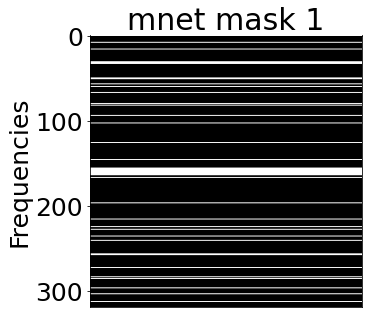

In [13]:
img_1  = imgs[imgind_1,:,:].view(1,1,heg,wid)/torch.max(torch.abs(imgs[imgind_1,:,:]))
kimg_1 = F.fftshift(F.fftn(img_1,dim=(2,3),norm='ortho').to(torch.cfloat)) # kspace shifted
lfmask,_,_ = mask_naiveRand(heg,fix=preselect_num,other=0,roll=True)
rdmask,_,_ = mask_naiveRand(heg,fix=preselect_num,other=budget,roll=True)

kimg_lf_1 = torch.zeros(1,2,heg,wid)    
kimg_lf_1[:,0,lfmask==1,:] = torch.real(kimg_1[:,:,lfmask==1,:])
kimg_lf_1[:,1,lfmask==1,:] = torch.imag(kimg_1[:,:,lfmask==1,:])
# _,loupe_mask = loupe.samplers[0](kimg,sparsity)
# loupe_mask = torch.squeeze(loupe_mask.detach())
# kplot(loupe_mask,roll=True)

mnet_mask_1 = mnet_wrapper(mnet,kimg_lf_1,budget=int(heg*sparsity)-preselect_num,\
                             imgshape=[heg,wid],normalize=True,detach=True)
mnet_mask_1 = torch.squeeze(mnet_mask_1)

# greedy_mask_1 = labels[imgind_1,:]

kplot(mnet_mask_1,roll=False,img_name='mnet mask 1')
# print('quality of mnet mask for image 1: ', mask_eval(mnet_mask_1.view(-1,320),img_1.view(1,heg,wid),\
#               mode='UNET',UNET=unet_recon,dtyp=torch.float,\
#               Lambda=10**(-4.3),hfen=False))

# kplot(greedy_mask_1,roll=False,img_name='greedy mask 1')
# print('quality of greedy mask for image 1: ',mask_eval(greedy_mask_1.view(-1,320),img_1.view(1,heg,wid),\
#               mode='UNET',UNET=unet_recon,dtyp=torch.float,\
#               Lambda=10**(-4.3),hfen=False))

imgind:  693


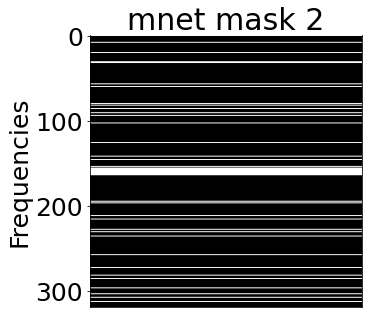

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

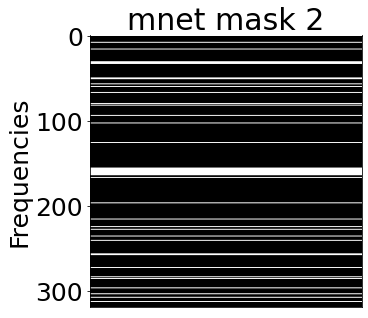

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

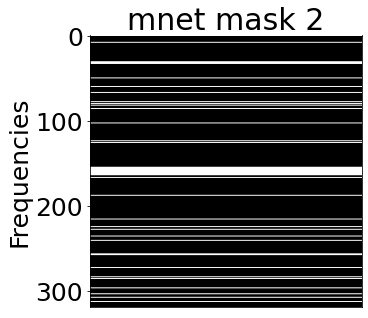

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

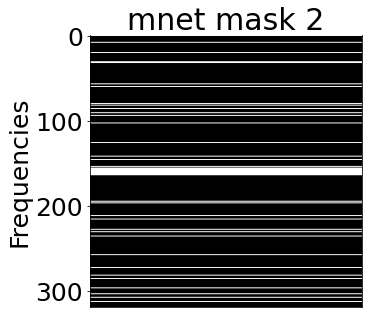

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

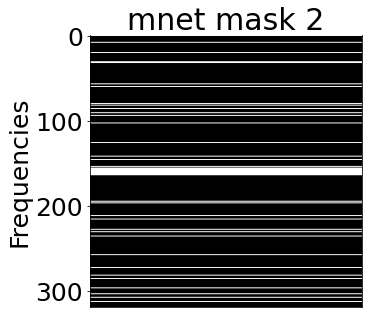

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

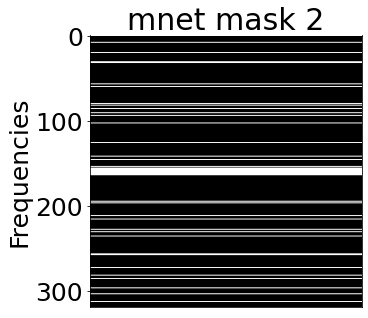

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

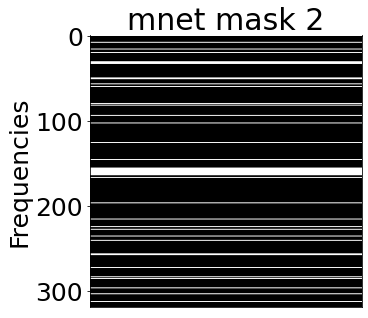

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

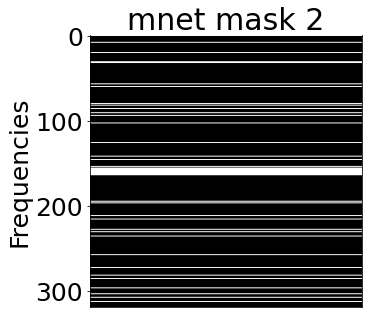

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

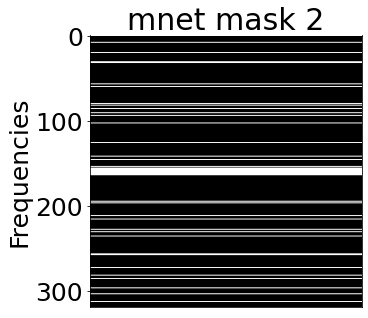

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

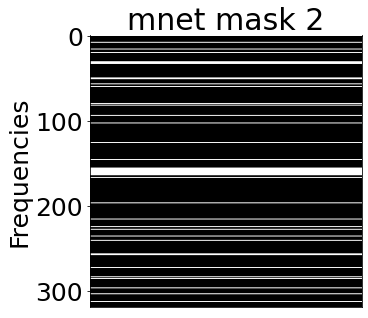

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

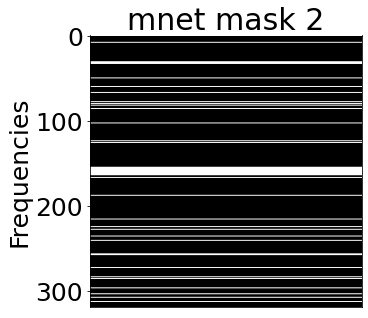

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

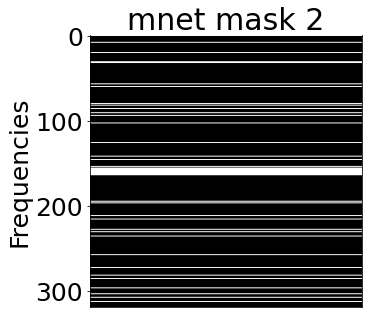

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

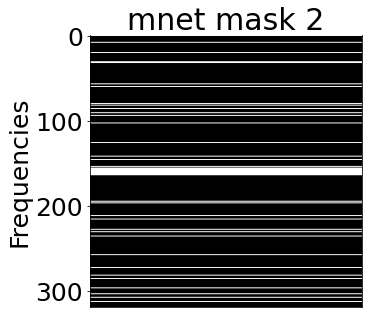

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

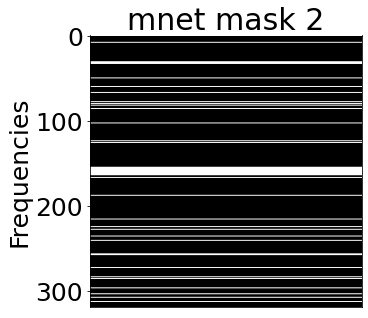

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

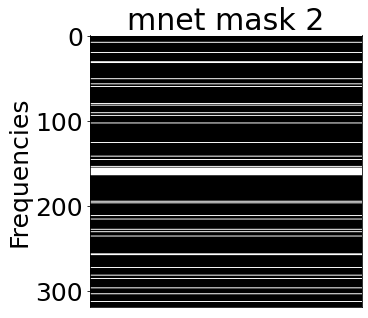

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

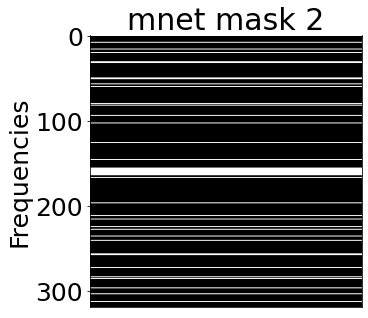

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

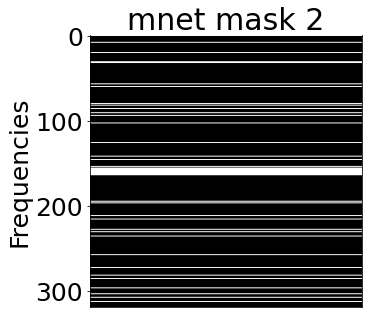

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

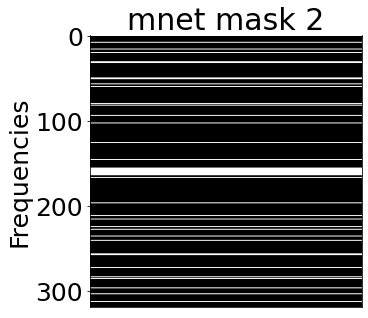

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

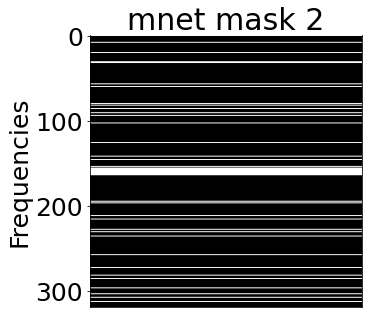

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

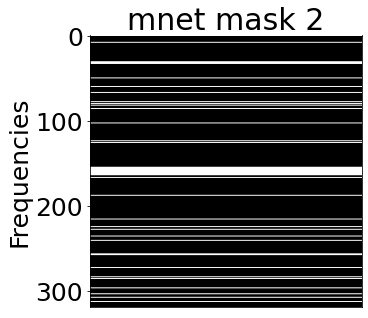

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

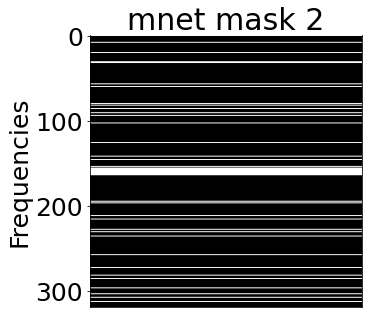

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

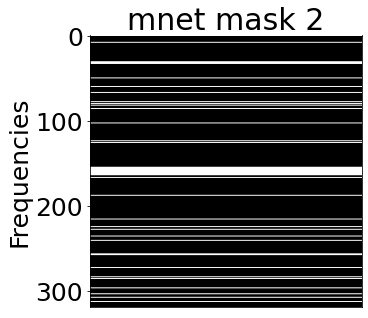

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

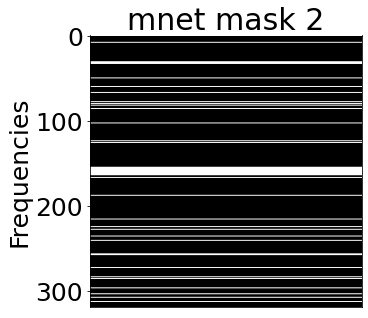

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

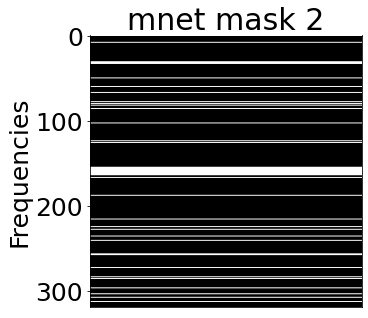

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

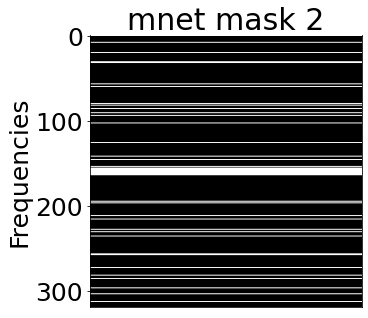

mask difference:  tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [14]:
for imgind_2 in np.random.choice(imgs.shape[0],size=30,replace=False):
# for imgind_2 in range(len(imgs)):
# imgind_2 = 693
    print('imgind: ',imgind_2)
    img_2 = imgs[imgind_2,:,:].view(1,1,heg,wid)/torch.max(torch.abs(imgs[imgind_2,:,:]))
    kimg_2 = F.fftshift(F.fftn(img_2,dim=(2,3),norm='ortho').to(torch.cfloat)) # kspace shifted

    kimg_lf_2 = torch.zeros(1,2,heg,wid)    
    kimg_lf_2[:,0,lfmask==1,:] = torch.real(kimg_2[:,:,lfmask==1,:])
    kimg_lf_2[:,1,lfmask==1,:] = torch.imag(kimg_2[:,:,lfmask==1,:])

    mnet_mask_2 = mnet_wrapper(mnet,kimg_lf_2,budget=int(heg*sparsity)-preselect_num,\
                                 imgshape=[heg,wid],normalize=True,detach=True)
    mnet_mask_2 = torch.squeeze(mnet_mask_2)

#   greedy_mask_2 = labels[imgind_2,:]    
#   kplot(greedy_mask_2,roll=False,img_name='greedy mask 2')

    slope = 1
    if (mnet_mask_1 - mnet_mask_2).abs().sum() > 0:
        kplot(mnet_mask_2,roll=False,img_name='mnet mask 2')
#         print('direct input difference: ',kimg_lf_1[:,:,lfmask==1,:] - kimg_lf_2[:,:,lfmask==1,:])
#         print('sigmoid mnet output difference: ',torch.sigmoid(slope * mnet(kimg_lf_1)) - torch.sigmoid(slope * mnet(kimg_lf_2)))
        print('mask difference: ', mnet_mask_1 - mnet_mask_2) 
        print('mnet total line count difference: ', (mnet_mask_1 - mnet_mask_2).abs().sum(),'\n')
    else:
        print('no diff \n')

In [ ]:
# image reconstruction
kimg_mn_1 = torch.zeros(1,1,heg,wid).to(torch.cfloat)   
kimg_mn_1[:,:,mnet_mask_1==1,:] = kimg_1[:,:,mnet_mask_1==1,:]
xifft_mn_1 = torch.abs( F.ifftn(F.ifftshift(kimg_mn_1),dim=(2,3),norm='ortho') ) # kspace shifted

kimg_rd_1 = torch.zeros(1,1,heg,wid).to(torch.cfloat)   
kimg_rd_1[:,:,rdmask==1,:] = kimg_1[:,:,rdmask==1,:]
xifft_rd_1 = torch.abs( F.ifftn(F.ifftshift(kimg_rd_1),dim=(2,3),norm='ortho') )

# kimg_gr_1 = torch.zeros(1,1,heg,wid).to(torch.cfloat)  
# kimg_gr_1[:,:,greedy_mask_1==1,:] = kimg_1[:,:,greedy_mask_1==1,:]
# xifft_gr_1 = torch.abs( F.ifftn(F.ifftshift(kimg_gr_1),dim=(2,3),norm='ortho') )

mode = 'unet'
# mode = 'sigpy'
if mode == 'unet':
    print(f'mode is {mode}')
    xrecon_mn_1 = unet_recon(xifft_mn_1).detach()
    xrecon_rd_1 = unet_recon(xifft_rd_1).detach()
#     xrecon_gr_1 = unet_recon(xifft_gr_1).detach()
    kplot(xrecon_mn_1[0,0,:,:],img_name='mnet-masked recon by unet')
    kplot(xrecon_rd_1[0,0,:,:],img_name='random-masked recon by unet')
#     kplot(xrecon_gr_1[0,0,:,:],img_name='greedy-masked recon by unet')
    kplot(torch.abs(xrecon_mn_1[0,0,:,:] - img_1[0,0,:,:]),img_name='mnet-recon error')
    kplot(torch.abs(xrecon_rd_1[0,0,:,:] - img_1[0,0,:,:]),img_name='random-recon error')
#     kplot(torch.abs(xrecon_gr_1[0,0,:,:] - img_1[0,0,:,:]),img_name='greedy-recon error')
    print(f'mode is {mode}')
    print('mnet   recon psnr: ',compute_psnr(xrecon_mn_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon psnr: ',compute_psnr(xrecon_rd_1.view(-1,320,320), img_1.view(-1,320,320)))
#     print('greedy recon psnr: ',compute_psnr(xrecon_gr_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon ssim: ',compute_ssim(xrecon_mn_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon ssim: ',compute_ssim(xrecon_rd_1.view(-1,320,320), img_1.view(-1,320,320)))
#     print('greedy recon ssim: ',compute_ssim(xrecon_gr_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon l2 err: ',(torch.norm(xrecon_mn_1-img_1)/torch.norm(img_1)).item())
    print('random recon l2 err: ',(torch.norm(xrecon_rd_1-img_1)/torch.norm(img_1)).item())
#     print('greedy recon l2 err: ',(torch.norm(xrecon_gr_1-img_1)/torch.norm(img_1)).item())
    print('\n')
    print('mnet   recon l1 err: ',(torch.norm(xrecon_mn_1-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('random recon l1 err: ',(torch.norm(xrecon_rd_1-img_1,p=1)/torch.norm(img_1,p=1)).item())
#     print('greedy recon l1 err: ',(torch.norm(xrecon_gr_1-img_1,p=1)/torch.norm(img_1,p=1)).item())
    
elif mode == 'sigpy':
    print(f'mode is {mode}')
    mps = np.ones((1,320,320))
    Lambda = 1e-4
    kimg_mn_1 = kimg_mn_1.view(-1,320,320).numpy()
    xrecon_mn_1 = np.fft.ifftshift( np.abs(TotalVariationRecon(kimg_mn_1, mps, Lambda,show_pbar=False).run()) )
    
    kimg_rd_1 = kimg_rd_1.view(-1,320,320).numpy()
    xrecon_rd_1 = np.fft.ifftshift( np.abs(TotalVariationRecon(kimg_rd_1, mps, Lambda,show_pbar=False).run()) )
    
    kimg_gr_1 = kimg_gr_1.view(-1,320,320).numpy()
    xrecon_gr_1 = np.fft.ifftshift( np.abs(TotalVariationRecon(kimg_gr_1, mps, Lambda,show_pbar=False).run()) )
    
    kplot(xrecon_mn_1,img_name='mnet-masked recon by sigpy')
    kplot(xrecon_rd_1,img_name='random-masked recon by sigpy')
    kplot(xrecon_gr_1,img_name='greedy-masked recon by sigpy')
    kplot(np.abs(xrecon_mn_1 - img_1[0,0,:,:].numpy()),img_name='mnet-recon error')
    kplot(np.abs(xrecon_rd_1 - img_1[0,0,:,:].numpy()),img_name='random-recon error')
    kplot(np.abs(xrecon_gr_1 - img_1[0,0,:,:].numpy()),img_name='greedy-recon error')
    print(f'mode is {mode}')
    print('mnet   recon psnr: ',compute_psnr(torch.tensor(xrecon_mn_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon psnr: ',compute_psnr(torch.tensor(xrecon_rd_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('greedy recon psnr: ',compute_psnr(torch.tensor(xrecon_gr_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon ssim: ',compute_ssim(torch.tensor(xrecon_mn_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon ssim: ',compute_ssim(torch.tensor(xrecon_rd_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('greedy recon ssim: ',compute_ssim(torch.tensor(xrecon_gr_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon l2 err: ',(torch.norm(torch.tensor(xrecon_mn_1).view(img_1.shape)-img_1)/torch.norm(img_1)).item())
    print('random recon l2 err: ',(torch.norm(torch.tensor(xrecon_rd_1).view(img_1.shape)-img_1)/torch.norm(img_1)).item())
    print('greedy recon l2 err: ',(torch.norm(torch.tensor(xrecon_gr_1).view(img_1.shape)-img_1)/torch.norm(img_1)).item())
    print('\n')
    print('mnet   recon l1 err: ',(torch.norm(torch.tensor(xrecon_mn_1).view(img_1.shape)-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('random recon l1 err: ',(torch.norm(torch.tensor(xrecon_rd_1).view(img_1.shape)-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('greedy recon l1 err: ',(torch.norm(torch.tensor(xrecon_gr_1).view(img_1.shape)-img_1,p=1)/torch.norm(img_1,p=1)).item())
    

# mnet and loupe training error check

In [ ]:
rec = np.load('/home/huangz78/checkpoints/mnet_train_history.npz')
print(rec.files)

In [ ]:
wid1 = 10
wid2 = 5
plt.figure()
plt.plot(rolling_mean(rec['precision_train'],wid1),label='precision')
plt.plot(rolling_mean(rec['recall_train'],wid1),label='recall')
plt.title('training accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('testing accuracy')
plt.plot(rolling_mean(rec['precision_test'],wid2),label='precision')
plt.plot(rolling_mean(rec['recall_test'],wid2),label='recall')
plt.legend()
plt.show()

plt.figure()
plt.title('train loss in cross entropy')
plt.plot(rolling_mean(rec['loss_train'],20),label='train')
plt.legend()
plt.show()

plt.figure()
plt.title('test loss in cross entropy')
plt.plot(rolling_mean(rec['loss'],8),color='orange',label='test')
plt.legend()
plt.show()


In [ ]:
rec = np.load('/home/huangz78/checkpoints/loupe_history.npz')

In [ ]:
loss_train = rec['loss_train']
loss_val = rec['loss_val']
plt.figure()
plt.plot(loss_train)
plt.xscale('log')
plt.yscale('log')
plt.title('training loss')
plt.show()
plt.figure()
plt.plot(loss_val)
plt.yscale('log')
plt.title('validation loss')
plt.show()

In [ ]:
def rolling_mean(x,window):
    window = int(window)
#   y = np.zeros(x.size-window)
#   for ind in range(y.size):
#       y[ind] = np.mean(x[ind:ind+window])

    # Stephen: for large data, the above gets a bit slow, so we can do this:
#   y = np.convolve(x, np.ones(window)/window, mode='valid')
#   return y
    # or https://stackoverflow.com/a/27681394
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

In [ ]:
rec = np.load('/mnt/shared_a/checkpoints/leo/mri/alternating_update_error_track_v2_8fold_unet_in_chan_1.npz')
# rec = np.load('/home/huangz78/checkpoints/alternating_update_error_track_8fold_unet_in_chan_1.npz')
print(rec.files)

burn = 0
loss_rand   = rec['loss_rand'][burn:]
loss_before = rec['loss_before'][burn:]
loss_after  = rec['loss_after'][burn:]

print(loss_rand.shape)

In [ ]:
rec = np.load('/mnt/shared_a/checkpoints/leo/mri/alternating_update_error_track_v2_8fold_unet_in_chan_1.npz')
print(rec.files)
# loss_vals = list(rec['loss_val'])
# loss_vals.append(0.10742834150791167)
# print(loss_vals)

figsize=(10,6)
window = 500
burn = 0
loss_rand   = rec['loss_rand'][burn:]
loss_before = rec['loss_before'][burn:]
loss_after  = rec['loss_after'][burn:]

binds = np.logical_and((loss_before!=np.inf) , np.logical_not(np.isnan(loss_before)))
ainds = np.logical_and((loss_after !=np.inf) , np.logical_not(np.isnan(loss_after )))
rinds = np.logical_and((loss_rand  !=np.inf) , np.logical_not(np.isnan(loss_rand  )))
inds  = np.logical_and(np.logical_and(binds,ainds),rinds)

plt.figure(figsize=figsize)
plt.plot(rolling_mean(loss_rand[inds]  ,window), label='loss random')
plt.plot(rolling_mean(loss_before[inds],window), label='loss mnet_pred')
plt.plot(rolling_mean(loss_after[inds] ,window), label='loss mask_backward')
plt.title('training mask loss')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=figsize)
plt.plot(rolling_mean(loss_before[inds] - loss_rand[inds] , window), label='mnet_pred - random')
plt.plot(rolling_mean(loss_before[inds] - loss_after[inds], window), label='mnet_pred - mask_backward')
zero_line = np.zeros((len(loss_rand[inds])))
plt.plot(zero_line,'--',label='zero threshold',color='r',linewidth=5)
plt.title('training mask loss difference comparison')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=figsize)
plt.plot(rec['loss_val'])
plt.title('validation loss')
# plt.xscale('log')
plt.yscale('log')
plt.show()

# mnet quality check: y

In [ ]:
net = MNet(beta=1,in_channels=2,out_size=320-24,\
                   imgsize=(320,320),poolk=3)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet.pth')
net.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet.pth')
net.eval()

imgs = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
base = 24
mask_lf,_,_ = mask_naiveRand(imgs.shape[1],fix=base,other=0,roll=True)

yfulls = torch.zeros((imgs.shape[0],2,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
ys     = torch.zeros((imgs.shape[0],2,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
xs     = torch.zeros((imgs.shape[0],1,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
for ind in range(imgs.shape[0]):
    imgs[ind,:,:] = imgs[ind,:,:]/torch.max(torch.abs(imgs[ind,:,:]))
    y = torch.fft.fftshift(F.fftn(imgs[ind,:,:],dim=(0,1),norm='ortho'))
    ysub = torch.zeros(y.shape,dtype=y.dtype)
    ysub[mask_lf==1,:] = y[mask_lf==1,:]
    xs[ind,0,:,:] = torch.abs(F.ifftn(torch.fft.ifftshift(ysub),dim=(0,1),norm='ortho')) 

    yfulls[ind,0,:,:] = torch.real(y)
    yfulls[ind,1,:,:] = torch.imag(y)
    ys[ind,:,mask_lf==1,:] = yfulls[ind,:,mask_lf==1,:]

labels = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled

imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))
test_total  = testinds.size

traindata   = ys[traininds,:,:,:]
valdata     = ys[testinds[0:test_total//2],:,:,:]

trainlabels = mask_filter(labels[traininds,:],base=base)
vallabels   = mask_filter(labels[testinds[0:test_total//2],:],base=base)

In [ ]:
imgind = 19
testimg  = valdata[imgind,:,:,:]
output_1 = net(testimg.view(-1,2,320,320))
binary_1 = sigmoid_binarize(output_1)[0,:]
greedy_1 = vallabels[imgind,:]

imgind = 13
testimg = valdata[imgind,:,:,:]
output_2 = net(testimg.view(-1,2,320,320))
binary_2 = sigmoid_binarize(output_2)[0,:]
greedy_2 = vallabels[imgind,:]

print(torch.sum(torch.abs(binary_1-binary_2)))
print(output_1 - output_2)
# sigmoid_binarize(output)[0,:]

In [ ]:
from utils import mask_complete

In [ ]:
mask_1 = mask_complete(binary_1.view(1,-1),320,rolled=True)
kplot(mask_1.view(-1))
kplot(greedy_1)

# mnet quality check: x

In [ ]:
def mnet_weights_init(m):
    classname = m.__class__.__name__
    print(m)
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# generate a mnet mask as an example

mnet = MNet(out_size=320-24)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet_split_trained.pth')
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet_split_trained.pth')

test_dir = '/home/huangz78/data/testdata_x.npz'
# testimg  = torch.tensor(np.load(test_dir)['x']) 
# print(testimg.shape)
# test_sub  = test_sub[0:10,:,:]
test_full = torch.tensor(np.load(test_dir)['xfull']) 
mask_greedy = np.load('/home/huangz78/data/data_gt_greedymask.npz')
mask_greedy = mask_greedy['mask'].T # this greedy mask is rolled

In [ ]:
reload(utils)
from utils import mnet_wrapper

In [ ]:
# imgind = np.random.randint(test_full.shape[0])
mnet.train()
imgind1 = np.random.randint(199)
print('current selected image is indexed: ',imgind1)
img1 = test_full[imgind1,:,:]
imgind2 = np.random.randint(199)
print('current selected image is indexed: ',imgind2)
img2 = test_full[imgind2,:,:]
# plt.imshow(img)
# plt.show()

budget = 56
lowfreqmask,_,_ = mask_naiveRand(img1.shape[0],fix=24,other=0,roll=True)
# randmask,_,_ = mask_naiveRand(img.shape[0],fix=24,other=budget,roll=True)
# kplot(randmask)

yfull1 = torch.fft.fftshift(F.fftn(img1,dim=(0,1),norm='ortho')) # y is ROLLED in this line!
yfull2 = torch.fft.fftshift(F.fftn(img2,dim=(0,1),norm='ortho')) # y is ROLLED!
yfull  = torch.stack((yfull1,yfull2),dim=0)
# x_lf_minus      = -x_lf.clone()
x_lf   = get_x_f_from_yfull(lowfreqmask,yfull,DTyp=torch.cfloat)

In [ ]:
mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) ).shape

In [ ]:
yfull1.shape

In [ ]:
mnet.eval()
mnetmask = mnet( 1e3*torch.randn(10,1,img1.shape[0],img1.shape[1]) )
# x_lf =  1e3*torch.randn(10,img1.shape[0],img1.shape[1]) 
# highmask_raw = mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) )
# mnetmask = mnet_wrapper(mnet,x_lf,budget,img1.shape)
print(mnetmask.shape)

torch.sum( torch.abs( mnetmask[0,:] - mnetmask[1,:] ) )

In [ ]:
a = torch.randn(2,2,4,5)
b = torch.randn(2,2,4,5)
c = a[:,0,:,:] + b[:,1,:,:]
print(c.shape)

In [ ]:
highmask_raw  = mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) ).view(-1)  # no sigmoid 
# highmask_raw  = mnet( 1e10*torch.randn(1,1,img.shape[0],img.shape[1]) ).view(-1)  # no sigmoid 
# print('highmask_raw = ', highmask_raw)
plt.plot(highmask_raw.detach().numpy())
plt.show()
mnetmask = mnet_wrapper(mnet,x_lf,budget,img.shape)
kplot(mnetmask)
kplot(mask_greedy[imgind,:])

In [ ]:
print(mnet.)

In [ ]:
for param in mnet.named_parameters():
      print(param)

In [ ]:
mnetmask_old = mnetmask.clone()
mnetmask - mnetmask_old

In [ ]:
randqual[1:]

In [ ]:
# show quality of mnet
filepath = '/home/huangz78/checkpoints/alternating_update_error_track.npz'
data_loss = np.load(filepath)

print(data_loss.files)

randqual   = data_loss['randqual']
mnetqual   = data_loss['mnetqual']
greedyqual = data_loss['greedyqual']
randspar   = data_loss['randspar']
mnetspar   = data_loss['mnetspar']

try:
    visualization(randqual[1:],mnetqual[1:],greedyqual=greedyqual,\
             randspar=randspar,mnetspar=mnetspar,greedyspar=greedyspar*np.ones(len(greedyqual)))
except Exception:
    visualization(randqual[1:],mnetqual[1:],randspar=randspar,mnetspar=mnetspar,log1=True)